In [1]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

# Calibration A

In [15]:
# Get calibration dataframe
c_df = get_calibrate_df('2021-12-14', '../data/calibration_A')
c_df = c_df[['Sensor', 'PM2.5']]

# figure folder
fig_folder = '../results/calibration_A'

## 1 Overall initial statistics

General statistics for the whole dataset.

In [16]:
param = 'PM2.5'

grand_mean = c_df[param].mean()
grand_median = c_df[param].median()
grand_mode = c_df[param].mode()
grand_std = c_df[param].std()

c_df[param].describe()

count    16840.000000
mean         0.616841
std          0.125099
min          0.280000
25%          0.530000
50%          0.610000
75%          0.700000
max          1.210000
Name: PM2.5, dtype: float64

#### Standard deviations, etc.

The "grand std" shows how much every sample varies from the total mean. The coefficient of variation is computed as follows:

$$CV = \frac{\sigma}{grand\ mean}$$

In [17]:
CV = grand_std / grand_mean
CV

0.20280527532700063

*How much do the medians vary from the total median?* (same formula as standard deviation but with medians)

In [18]:
median_diff = 0

for sensor, grp in c_df.groupby('Sensor'):
    median_diff += (grp[param].median() - grand_median) ** 2
    
median_diff = np.sqrt(median_diff / (len(c_df['Sensor'].unique()) - 1))

median_diff

0.0447213595499958

## 2 Central tendency and variability

In [19]:
central = c_df.groupby('Sensor').agg(
    {param: 
     ['mean', 'median', mode, 'min', 'max', x_range, sample_std, standard_error, CI95]
    }
)

central.head()

PM2.5                                                             \
            mean median  mode   min   max x_range sample_std standard_error   
Sensor                                                                        
1       0.570914   0.56  0.52  0.31  0.86    0.55   0.105410       0.001988   
2       0.641293   0.64  0.58  0.32  1.05    0.73   0.123486       0.002334   
3       0.680662   0.68  0.70  0.33  1.21    0.88   0.145926       0.002753   
4       0.582613   0.57  0.58  0.31  0.87    0.56   0.101945       0.001925   
5       0.603684   0.60  0.56  0.31  0.95    0.64   0.109201       0.002061   

                  
            CI95  
Sensor            
1       0.003897  
2       0.004574  
3       0.005396  
4       0.003773  
5       0.004040

**Comment**

Sensor 3 has the largest range and highest standard deviation. Sensor 1 has the lowest range. Sensor 4 has the lowest standard deviation.

## 3 Distribution
How is the data distributed?

### 3.1 Box plots

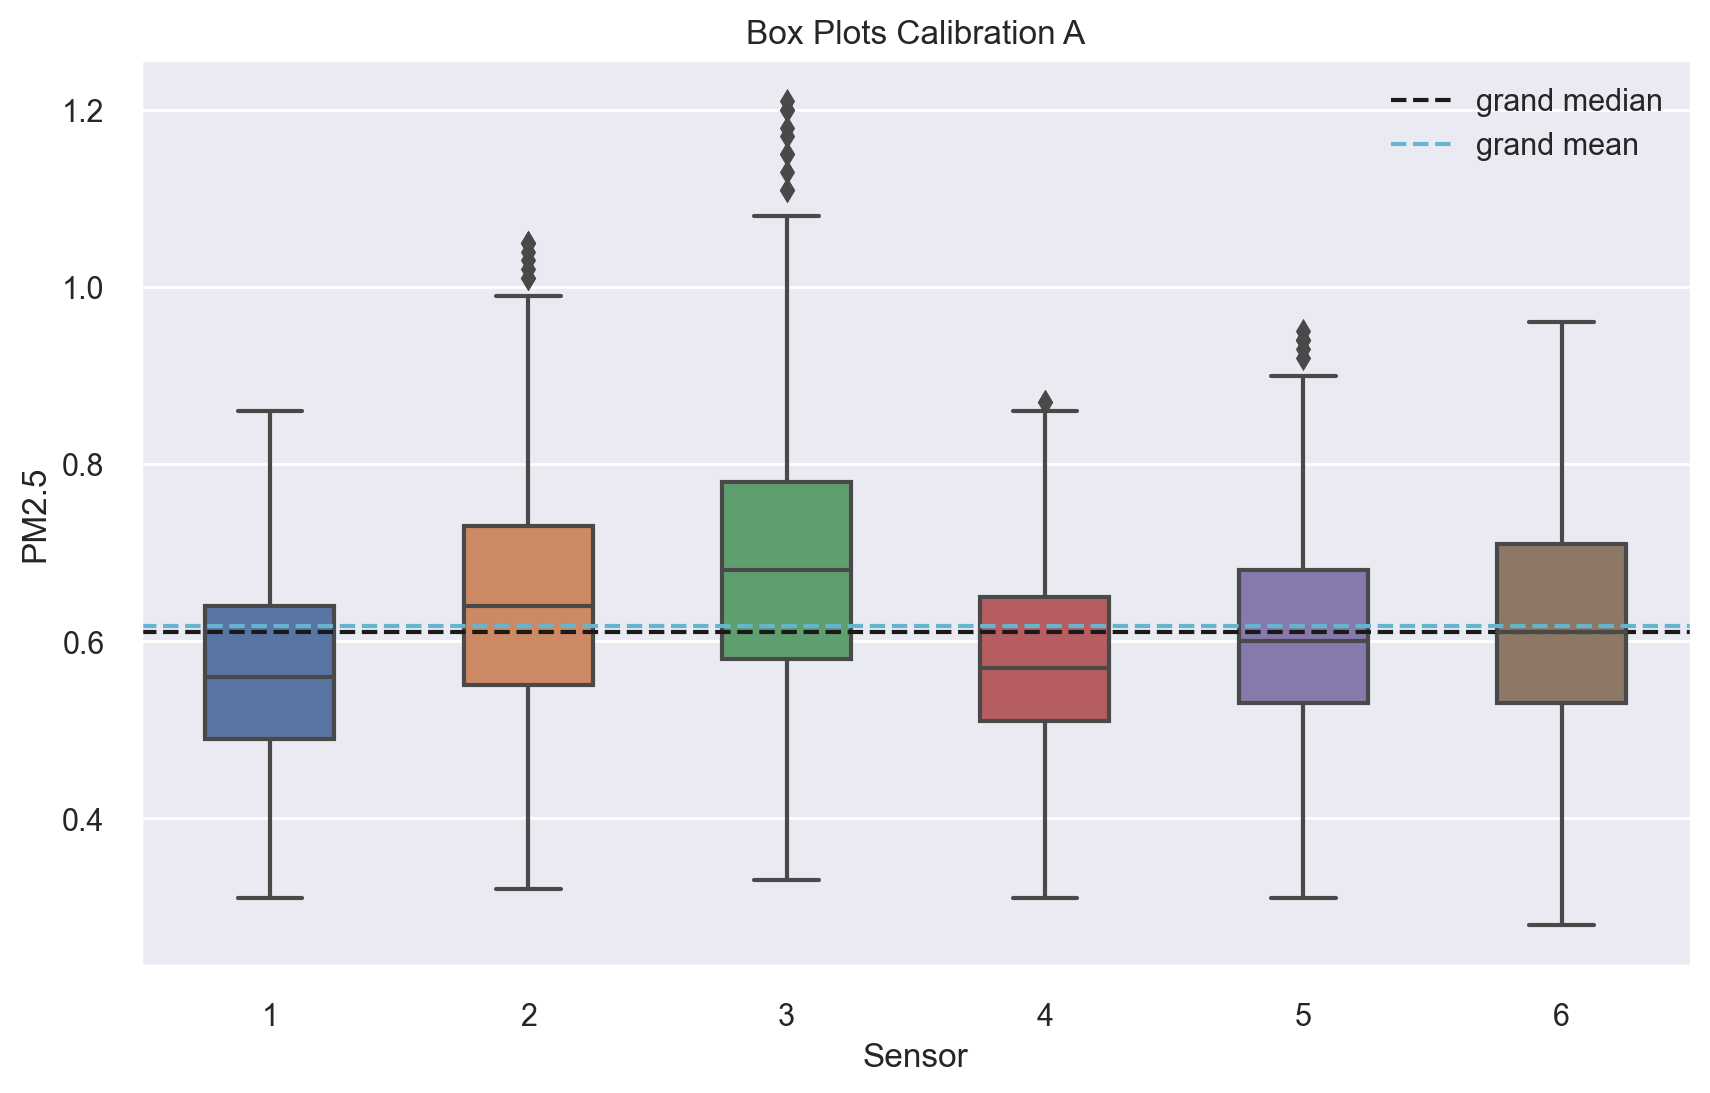

In [24]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=c_df, width=0.5)

plt.axhline(c_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(c_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Calibration A')
plt.savefig(f'{fig_folder}/box_plots{param}.pdf')
plt.show()

**Comment**

From the boxplot, we can see that we have outliers. Mostly from sensors 2, 3, and 5. As the environment was controlled for during the calibration and assumed to be stable, these outliers are seen as errors in the sensor readings. Let's evaluate the outliers.

Question: what should we do with outliers?
- *Remove them*: Will give more acurate statistics later on. In this case, it is probably the most sensible thing to do as we have so many records to compare with. If the number of outliers are small, they can be probably be seen as minor measurement deviations
- *Keep them*: How much will the outliers affect later statistics? In this case, we can determine outliers based on a large number of samples. On the station records, however, we do not have as many reference values. When comparing statistics from this dataset to the other datasets we want to keep the procedure as similar as possible.

### 3.2 Outliers

In [8]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = c_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles.head()

PM2.5                                                                  \
          Q1    Q2    Q3   IQR lowerLimit upperLimit outliers prcnt_outliers   
Sensor                                                                         
1       0.49  0.56  0.64  0.15      0.265      0.865      0.0       0.000000   
2       0.55  0.64  0.73  0.18      0.280      1.000      8.0       0.285714   
3       0.58  0.68  0.78  0.20      0.280      1.080     10.0       0.355872   
4       0.51  0.57  0.65  0.14      0.300      0.860      2.0       0.071301   
5       0.53  0.60  0.68  0.15      0.305      0.905      6.0       0.213751   

              
       count  
Sensor        
1       2811  
2       2800  
3       2810  
4       2805  
5       2807

In [9]:
# Get exact values of outliers
outliers_dict = {}

for sensor, grp in c_df.groupby('Sensor'):    
    lower = quantiles[param]['lowerLimit'][sensor]
    upper = quantiles[param]['upperLimit'][sensor]
    outliers_dict[sensor] = grp.loc[(grp[param] < lower) | (grp[param] > upper)][param].values

outliers_dict

{'1': array([], dtype=float64),
 '2': array([1.01, 1.03, 1.05, 1.05, 1.05, 1.04, 1.02, 1.01]),
 '3': array([1.11, 1.15, 1.17, 1.2 , 1.21, 1.2 , 1.18, 1.15, 1.13, 1.11]),
 '4': array([0.87, 0.87]),
 '5': array([0.92, 0.94, 0.94, 0.95, 0.94, 0.93]),
 '6': array([], dtype=float64)}

**Comment**

Sensor 3 has the most outliers, followed by Sensor 2, Sensor 5, Sensor 4, and lastly Sensor 1. Not that many outliers in comparison to the total amount of samples taken. However, 0.07-0.36% of sample points are still contributing to a slightly different mean.

### 3.3 Histograms

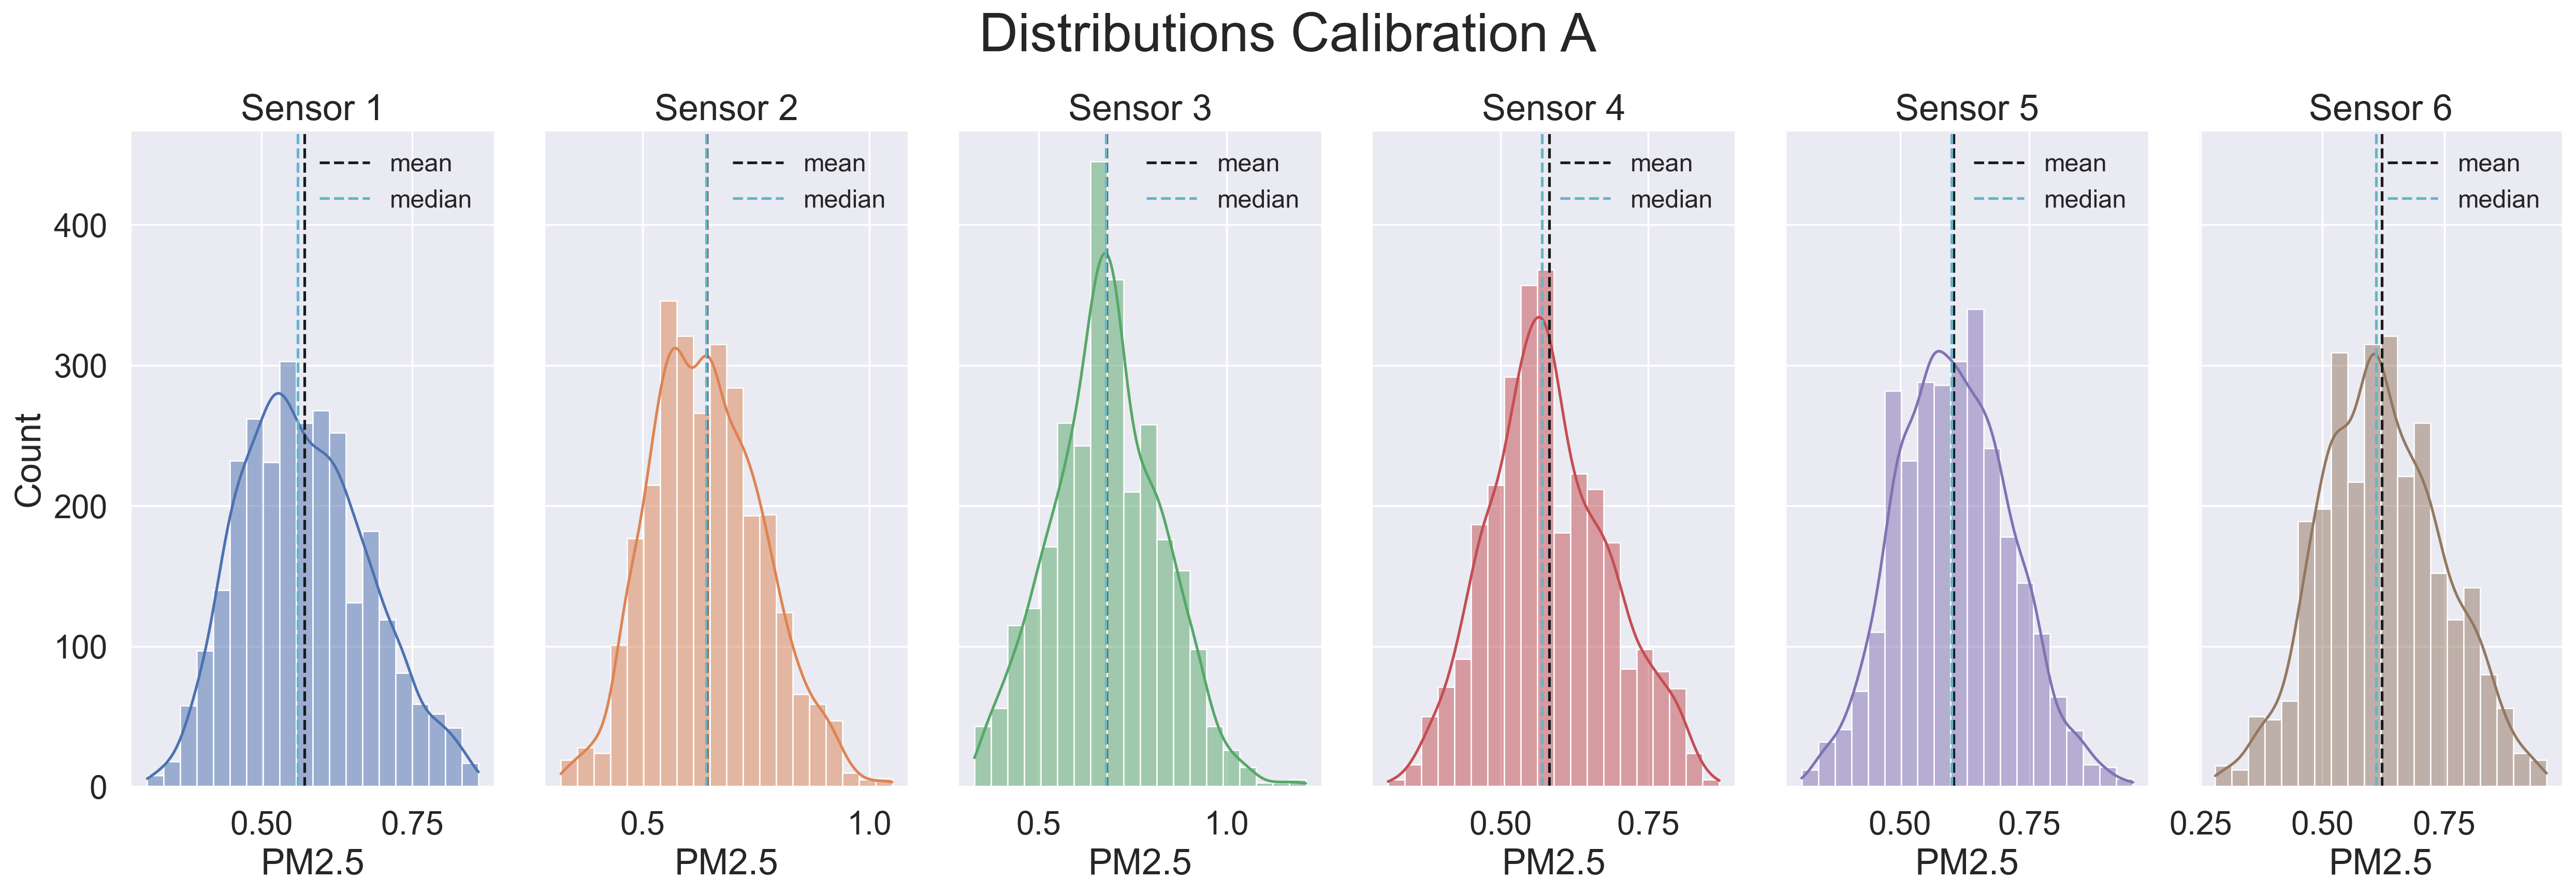

In [23]:
plot_sensor_distributions(
    c_df, 
    title='Distributions Calibration A', 
    fig_name=f'{fig_folder}/distributions{param}.pdf', 
    bins=20, 
    param=param
)

**Comment**

This gives us a nice general overview of the individual sensor distributions. They seem to roughly follow normal distributions, but to what extent? To get more exact values, let's use QQ-plots, skew, and kurtosis.

### 3.4 Normal distribution

In [11]:
normal = c_df.groupby('Sensor').agg({param: [skew, kurtosis]})

normal.head(10)

PM2.5          
            skew  kurtosis
Sensor                    
1       0.303538 -0.411906
2       0.256133 -0.184395
3       0.125521 -0.066265
4       0.232103 -0.322145
5       0.148537 -0.215805
6       0.112604 -0.300660

Compare with values

**Comment**

Sensor 1 has the highest absolute skew and kurtosis. Sensor 6 has the lowest skew while Sensor 3 has the least amount of kurtosis. This is interesting as Sensor 3 had the most outliers in numbers.

#### QQ Plots

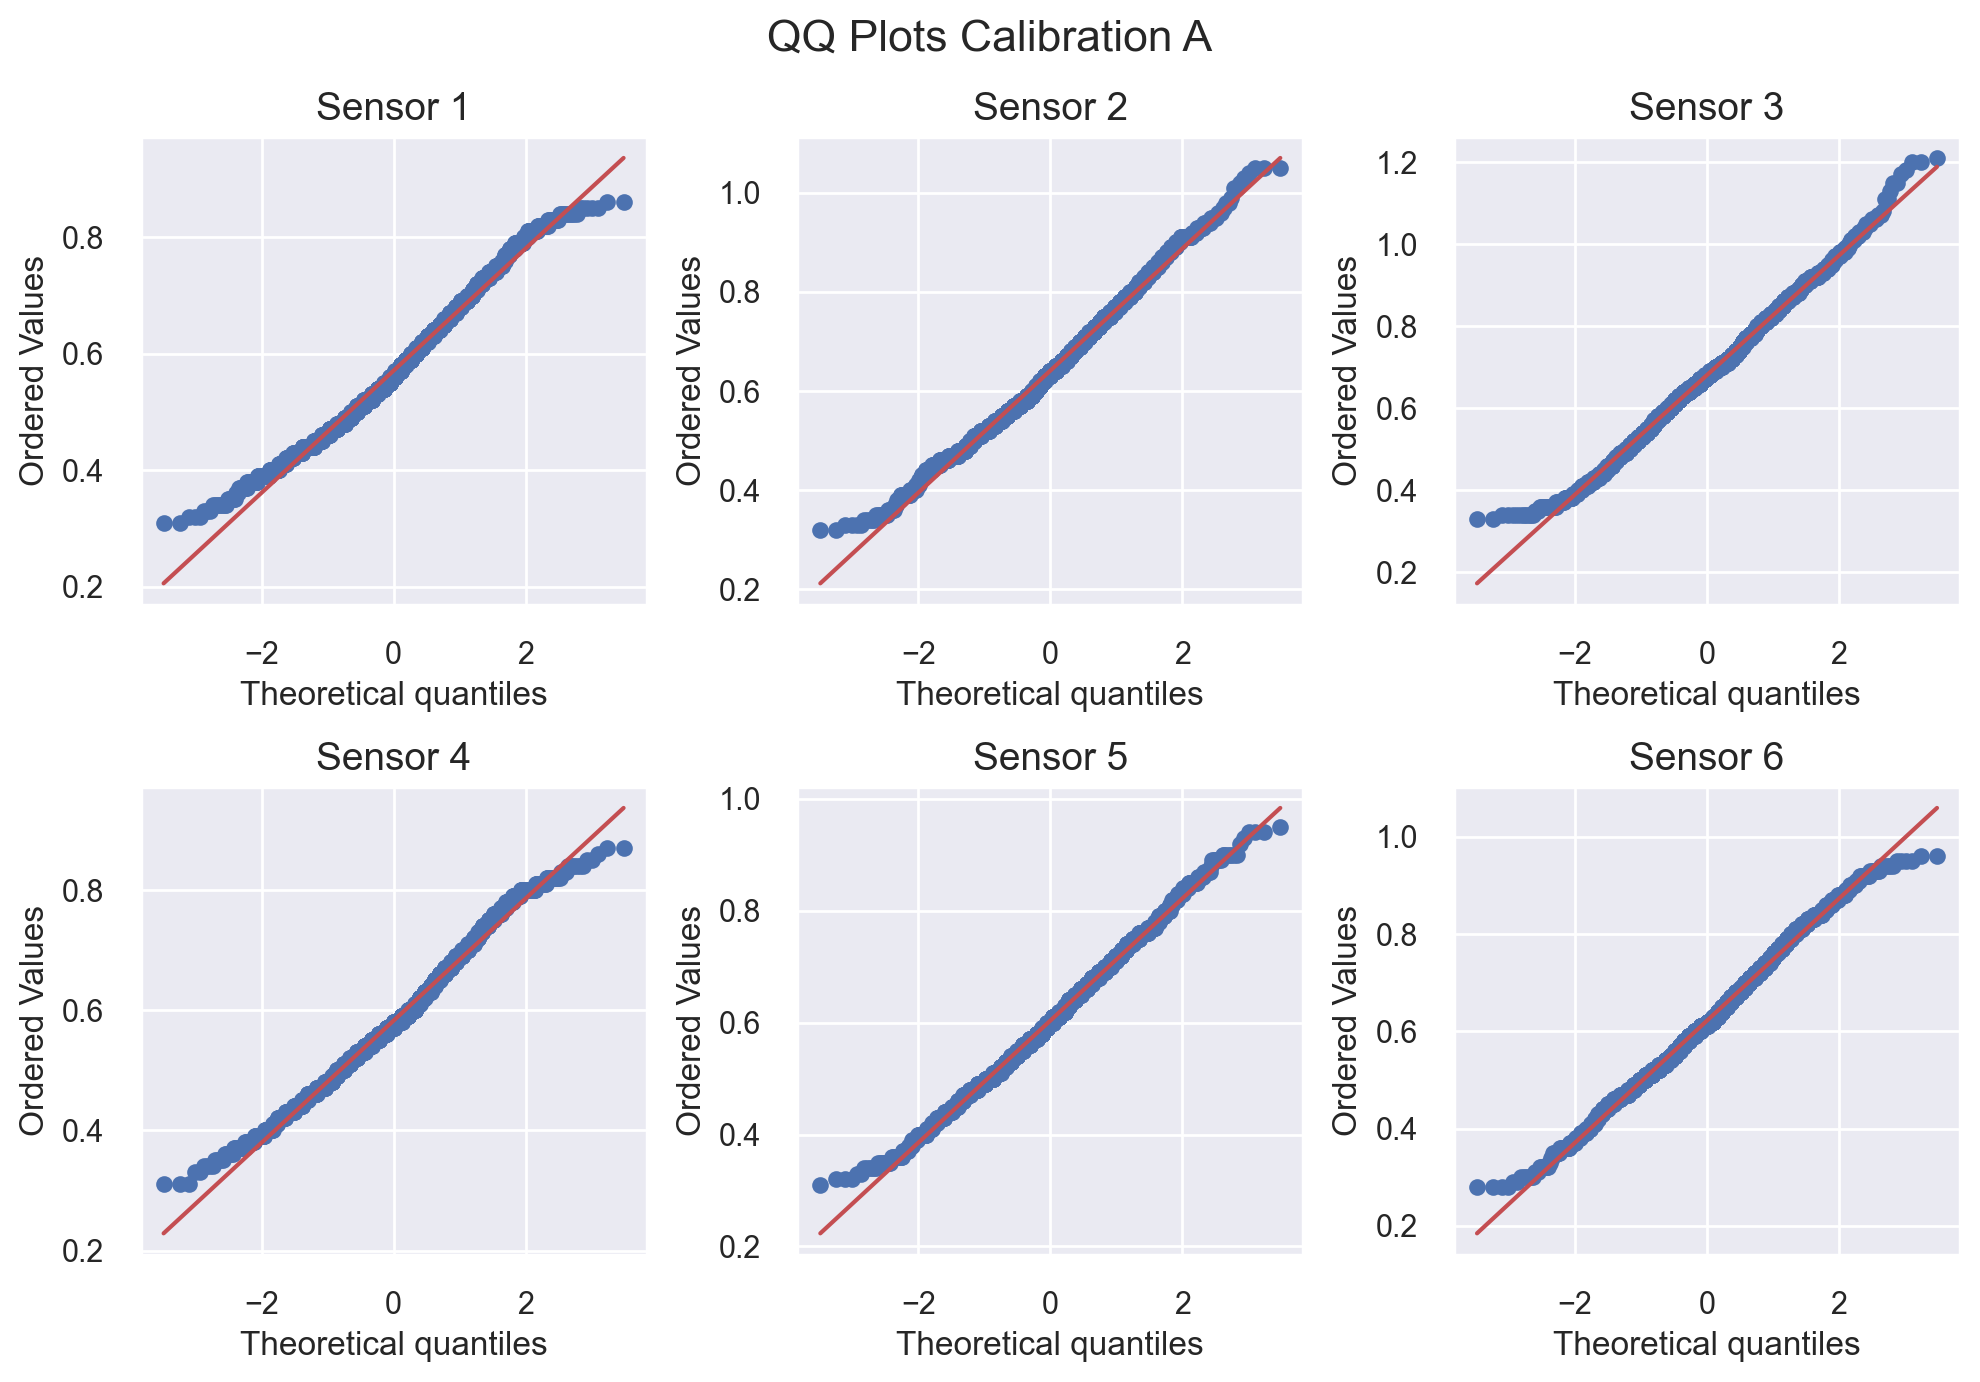

In [26]:
plot_QQ_plots(
    c_df, 
    title='QQ Plots Calibration A', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots{param}.pdf'
)

**Comment**

Based on visuals from the above graphs, all sensors seem to follow a normal distribution quite well.

## 4 Comparison among sensors and between them

### 4.1 Distribution

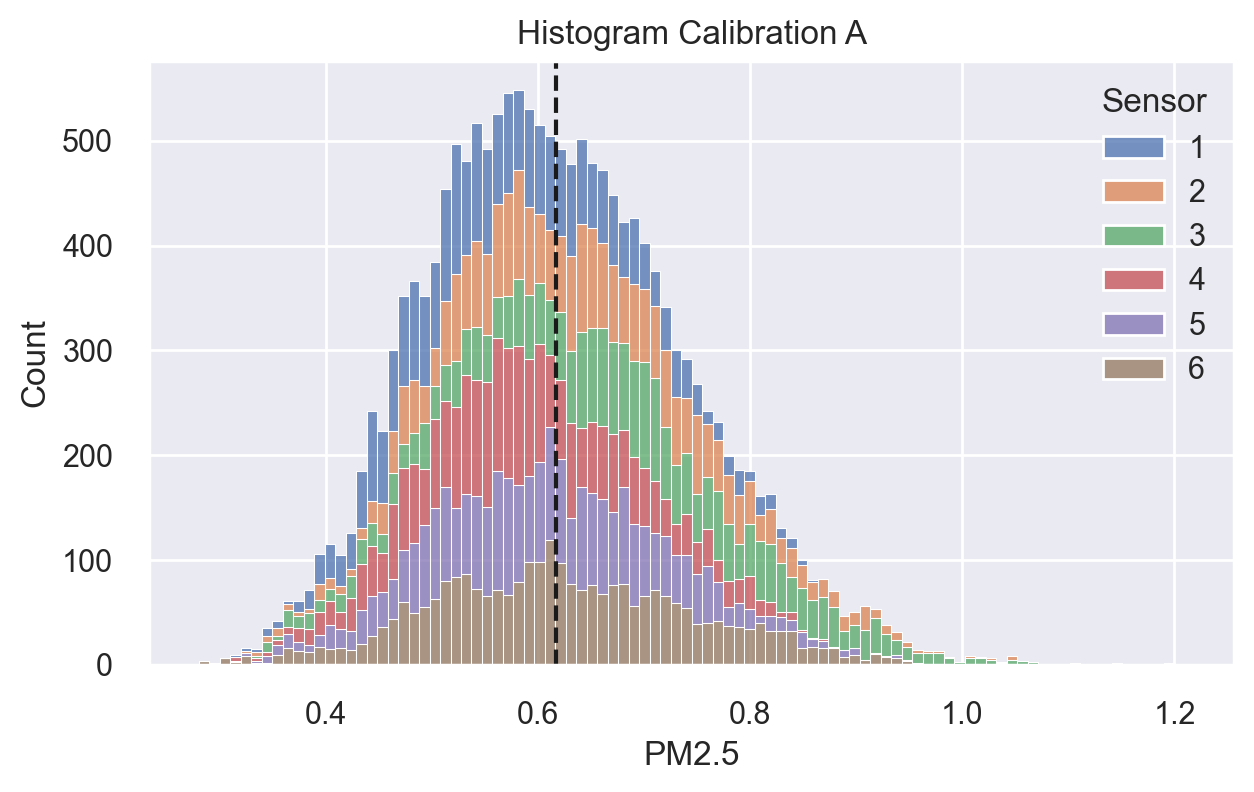

In [13]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(c_df, x=param, hue='Sensor', multiple='stack', bins=94)
plt.axvline(grand_mean, c='k', linestyle='--', label='mean', linewidth=1.5)
plt.title('Histogram Calibration A')


plt.show()

In [14]:
grand_skew = stats.skew(c_df[param], bias=False)
grand_kurtosis = stats.kurtosis(c_df[param], bias=False)

print(f'Skew: {grand_skew}')
print(f'Kurtosis: {grand_kurtosis}')
print(f'Std: {grand_std}')

Skew: 0.373857537365937
Kurtosis: 0.08151771399505581
Std: 0.125098579452895


**Comment**

Slightly longer tail on the right side (positive skew) than a normal distribution. Low kurtosis.

## 5 Other 

### 5.1 Pairplots

In [ ]:
pair_df = get_calibrate_df('2021-12-14', '../data/calibration_A')

pair_df = pair_df[['PM1.0', 'PM2.5', 'Temperature', 'Humidity', 'NC1.0', 'NC2.5', 'Sensor']]

sns.pairplot(pair_df, hue='Sensor')

#plt.savefig(fig_folder + 'pairplot.pdf')

plt.title('Pairplot Calibration A')
plt.show()